In [1]:
import numpy as np
import scipy.io as sio
import glob
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model, Input
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE


from tensorflow.keras import backend as K

#from tensorflow.keras import layers
#from tensorflow.keras import Sequential, Model

In [2]:
# find all ecg-files
data = np.load('data.npy')
l = np.load('l.npy')

In [3]:
l.shape, data.shape

((14579,), (14579, 501, 12))

In [4]:
for i, d in enumerate(data):
    #if i%200 ==0:
        #print(i) 
    data[i] = MinMaxScaler().fit_transform(d)
    

In [14]:
class Autoencoder(TransformerMixin, BaseEstimator):
    
    def __init__(self, n_components=144, signal_size=200):
        self.n_components = n_components
        
        num_channel = 12
        input_shape = (signal_size, num_channel)
        self.batch_size = 32
        self.kernel_size = 3
        self.latent_dim = n_components
        layer_filters = [64,64,64]

        encoder_input = Input(shape=input_shape, name='encoder_input')
        x = encoder_input
        
        shape = K.int_shape(x)
        print(shape)
        
        x = layers.Flatten()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        encoder_output = layers.Dense(n_components, activation='relu')(x)
        
        self.encoder = Model(inputs=encoder_input, outputs=encoder_output, name='encoder')
        
        decoder_input = Input(shape=(n_components,), name='decoder_input')
        x = decoder_input
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dense(2400, activation='relu')(x)
        x = layers.Reshape((shape[1], shape[2]))(x)
        
        self.decoder = Model(inputs=decoder_input, outputs=x, name='decoder')
        self.autoencoder = Model(inputs=encoder_input,outputs=self.decoder(self.encoder(encoder_input)),
                                 name='autoencoder')
        self.autoencoder.compile(loss='mse', optimizer='adam')
        

    def fit(self, X, y=None, epochs=32, batch_size=128, shuffle=True, verbose=1):
        self.autoencoder.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=shuffle,verbose=verbose)
        return self

    def transform(self, X, y=None):
        encoded_images = self.encoder.predict(X)
        return encoded_images
    
    def saveModels(self, prefix=""):
        # serialize model to JSON
        model_json = self.autoencoder.to_json()
        with open("{}_{}autoencoder.json".format(prefix, self.n_components), "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.autoencoder.save_weights("{}_{}autoencoder.h5".format(prefix, self.n_components))

        # serialize model to JSON
        model_json = self.encoder.to_json()
        with open("{}_{}encoder.json".format(prefix, self.n_components), "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.encoder.save_weights("{}_{}encoder.h5".format(prefix, self.n_components))

        # serialize model to JSON
        model_json = self.decoder.to_json()
        with open("{}_{}decoder.json".format(prefix, self.n_components), "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.decoder.save_weights("{}_{}decoder.h5".format(prefix, self.n_components))

In [15]:
data[:,:200,:].shape

(14579, 200, 12)

In [17]:
#ae = Autoencoder(n_components=144)
#ae.encoder.summary()
#ae.decoder.summary()
#ae.autoencoder.summary()
ae.autoencoder.fit(data[:,:200,:], data[:,:200,:], epochs=8, batch_size=256)

Train on 14579 samples
Epoch 1/8
14579/14579 [==============================] - 2s 171us/sample - loss: 0.0042
Epoch 2/8
14579/14579 [==============================] - 2s 167us/sample - loss: 0.0041
Epoch 3/8
14579/14579 [==============================] - 2s 170us/sample - loss: 0.0039
Epoch 4/8
14579/14579 [==============================] - 2s 169us/sample - loss: 0.0038
Epoch 5/8
14579/14579 [==============================] - 2s 167us/sample - loss: 0.0036
Epoch 6/8
14579/14579 [==============================] - 2s 169us/sample - loss: 0.0035
Epoch 7/8
14579/14579 [==============================] - 2s 168us/sample - loss: 0.0034
Epoch 8/8
14579/14579 [==============================] - 2s 168us/sample - loss: 0.0034


In [20]:

y_pred = ae.encoder.predict(data[:,:200,:])
X = TSNE(n_components=2).fit_transform(y_pred)


In [21]:
%matplotlib auto
plt.scatter(X[:,0], X[:,1],s=3,c=l)

Using matplotlib backend: Qt5Agg


In [37]:
inds0 = np.where(l==0)[0]
inds1 = np.where(l==0)[0]
#plt.scatter(X[inds0,0], X[inds0,1],s=3,c='b')
plt.scatter(X[inds1,0], X[inds1,1],s=3,c='r')

In [6]:
class Autoencoder(TransformerMixin, BaseEstimator):
    
    def __init__(self, n_components=8, signal_size=200):
        self.n_components = n_components
        
        num_channel = 12
        input_shape = (signal_size, num_channel)
        self.batch_size = 32
        self.kernel_size = 3
        self.latent_dim = n_components
        layer_filters = [64,64,64]

        encoder_input = Input(shape=input_shape, name='encoder_input')
        x = encoder_input
        x = layers.Permute((2,1))(x)
        
        x = layers.TimeDistributed(layers.Dense(256, activation='relu'))(x)
        x = layers.TimeDistributed(layers.Dense(128, activation='relu'))(x)
        x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x)
        #encoder_output = layers.TimeDistributed(layers.Dense(n_components, activation='relu'))(x)
        x = layers.TimeDistributed(layers.Dense(n_components, activation='relu'))(x)
        shape = K.int_shape(x)
        x = layers.Flatten()(x)
        x = layers.Dense(shape[1]*shape[2], activation='sigmoid')(x)
        encoder_output = x
        x = layers
        #encoder_output = layers.Dense(n_components, activation='relu')(x)
        
        self.encoder = Model(inputs=encoder_input, outputs=encoder_output, name='encoder')
        
        #decoder_input = Input(shape=(num_channel, n_components), name='decoder_input')
        decoder_input = Input(shape=(shape[1]*shape[2],), name='decoder_input')
        x = decoder_input
        x = layers.Reshape((shape[1], shape[2]))(x)
        x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x)
        x = layers.TimeDistributed(layers.Dense(128, activation='relu'))(x)
        x = layers.TimeDistributed(layers.Dense(256, activation='relu'))(x)
        x = layers.TimeDistributed(layers.Dense(200, activation='sigmoid'))(x)
        decoder_output = layers.Permute((2,1))(x)
        
        self.decoder = Model(inputs=decoder_input, outputs=decoder_output, name='decoder')
        
        self.autoencoder = Model(inputs=encoder_input,outputs=self.decoder(self.encoder(encoder_input)),
                                 name='autoencoder')
        
        self.autoencoder.compile(loss='mse', optimizer='adam')
        

    def fit(self, X, y=None, epochs=32, batch_size=128, shuffle=True, verbose=1):
        self.autoencoder.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=shuffle,verbose=verbose)
        return self

    def transform(self, X, y=None):
        encoded_images = self.encoder.predict(X)
        return encoded_images
    
    def saveModels(self, prefix=""):
        # serialize model to JSON
        model_json = self.autoencoder.to_json()
        with open("{}_{}autoencoder.json".format(prefix, self.n_components), "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.autoencoder.save_weights("{}_{}autoencoder.h5".format(prefix, self.n_components))

        # serialize model to JSON
        model_json = self.encoder.to_json()
        with open("{}_{}encoder.json".format(prefix, self.n_components), "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.encoder.save_weights("{}_{}encoder.h5".format(prefix, self.n_components))

        # serialize model to JSON
        model_json = self.decoder.to_json()
        with open("{}_{}decoder.json".format(prefix, self.n_components), "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.decoder.save_weights("{}_{}decoder.h5".format(prefix, self.n_components))

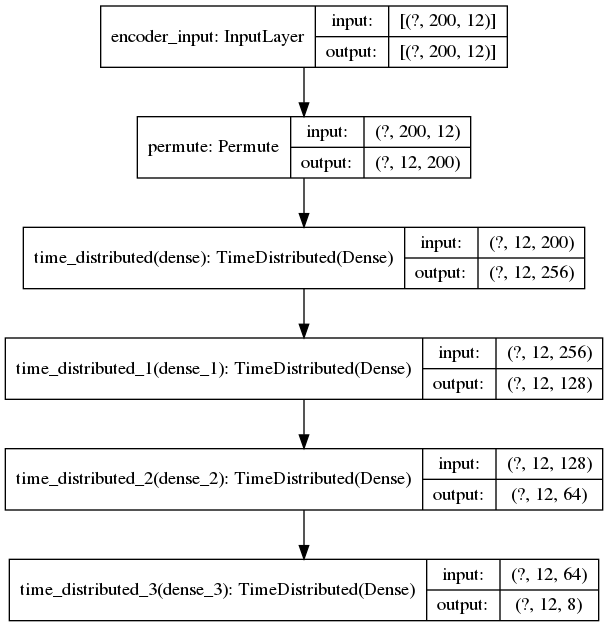

In [7]:
aetd = Autoencoder()

from tensorflow.keras.utils import plot_model

plot_model(aetd.encoder, show_shapes=True, to_file='td_autoencoder.png')

In [8]:
aetd.encoder.summary()
aetd.decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 200, 12)]         0         
_________________________________________________________________
permute (Permute)            (None, 12, 200)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 12, 256)           51456     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 128)           32896     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 64)            8256      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 12, 8)             520       
Total params: 93,128
Trainable params: 93,128
Non-trainable params: 0
_______________________________________________________

In [9]:
aetd.fit(data[:,:200,:], data[:,:200,:], epochs=8, batch_size=256, verbose=1)

Train on 14579 samples
Epoch 1/8
14579/14579 [==============================] - 3s 222us/sample - loss: 0.0506
Epoch 2/8
14579/14579 [==============================] - 2s 171us/sample - loss: 0.0159
Epoch 3/8
14579/14579 [==============================] - 3s 174us/sample - loss: 0.0111
Epoch 4/8
14579/14579 [==============================] - 2s 171us/sample - loss: 0.0078
Epoch 5/8
14579/14579 [==============================] - 3s 172us/sample - loss: 0.0072
Epoch 6/8
14579/14579 [==============================] - 3s 172us/sample - loss: 0.0069
Epoch 7/8
14579/14579 [==============================] - 3s 175us/sample - loss: 0.0063
Epoch 8/8
14579/14579 [==============================] - 3s 174us/sample - loss: 0.0058


/home/roland/anaconda3/envs/nonlin/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Autoencoder(n_components=8, signal_size=None)

In [16]:
y_pred = np.reshape(aetd.encoder.predict(data[:,:200,:]), (-1,12*8))
X = TSNE(n_components=2).fit_transform(y_pred)

In [17]:
%matplotlib auto
plt.scatter(X[:,0], X[:,1],s=3,c=l)

Using matplotlib backend: Qt5Agg


In [70]:
pred = aetd.encoder.predict(data[:,:200,:])

In [72]:
#plt.imshow(pred[2000])
#l[2000]

In [58]:
p = aetd.autoencoder.predict(data[:,:200,:])
#plt.plot(p[:,0])

([<matplotlib.lines.Line2D at 0x7f45483401d0>],
 [<matplotlib.lines.Line2D at 0x7f4548328750>])

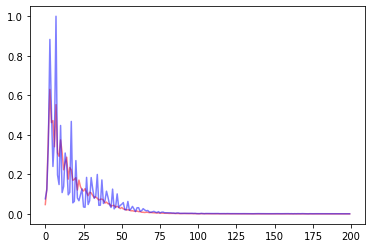

In [62]:
%matplotlib inline
plt.plot(p[0,:,0], c='r',alpha=0.5), plt.plot(data[0,:200,0],c='b',alpha=0.5
                                            )

In [14]:
n = 200
timestep = 1/5
freq = np.fft.fftfreq(n, d=timestep)
freq

array([ 0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,
        0.2  ,  0.225,  0.25 ,  0.275,  0.3  ,  0.325,  0.35 ,  0.375,
        0.4  ,  0.425,  0.45 ,  0.475,  0.5  ,  0.525,  0.55 ,  0.575,
        0.6  ,  0.625,  0.65 ,  0.675,  0.7  ,  0.725,  0.75 ,  0.775,
        0.8  ,  0.825,  0.85 ,  0.875,  0.9  ,  0.925,  0.95 ,  0.975,
        1.   ,  1.025,  1.05 ,  1.075,  1.1  ,  1.125,  1.15 ,  1.175,
        1.2  ,  1.225,  1.25 ,  1.275,  1.3  ,  1.325,  1.35 ,  1.375,
        1.4  ,  1.425,  1.45 ,  1.475,  1.5  ,  1.525,  1.55 ,  1.575,
        1.6  ,  1.625,  1.65 ,  1.675,  1.7  ,  1.725,  1.75 ,  1.775,
        1.8  ,  1.825,  1.85 ,  1.875,  1.9  ,  1.925,  1.95 ,  1.975,
        2.   ,  2.025,  2.05 ,  2.075,  2.1  ,  2.125,  2.15 ,  2.175,
        2.2  ,  2.225,  2.25 ,  2.275,  2.3  ,  2.325,  2.35 ,  2.375,
        2.4  ,  2.425,  2.45 ,  2.475, -2.5  , -2.475, -2.45 , -2.425,
       -2.4  , -2.375, -2.35 , -2.325, -2.3  , -2.275, -2.25 , -2.225,
      

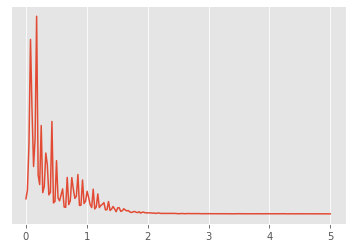

In [31]:
plt.style.use('ggplot')
freq = np.linspace(0,5,200)
plt.plot(freq, data[0,:200,0])
plt.yticks([])
plt.savefig('fourier_ex2.png', dpi = 300)